In [116]:
import itertools
import os
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import statsmodels.api as sm

In [117]:
df = pd.read_csv('/Users/manishabasak/Desktop/ML/CollegeScorecard_Raw_Data/MERGED2013_14_PP.csv')

/Users/manishabasak/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1537,1540,1542,1547,1548,1549,1561,1575,1606,1614,1615,1729) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [118]:
# outcome variable MN_EARN_WNE_P10 
df['MN_EARN_WNE_P10'] = pd.to_numeric(df.MN_EARN_WNE_P10.astype(str).str.replace(',',''), errors='coerce')

mean_earn_10 is 37454.08927989573


0.25    26600.0
0.50    34500.0
0.75    43600.0
0.80    46600.0
0.90    54200.0
0.91    55267.0
0.92    55800.0
0.93    56200.0
0.94    58000.0
0.95    59815.0
Name: MN_EARN_WNE_P10, dtype: float64

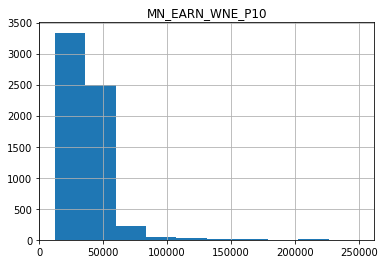

In [119]:
# statistics on the outcome variable
mean_earn_10 = df['MN_EARN_WNE_P10'].mean()
print("mean_earn_10 is", mean_earn_10)
df.hist(column='MN_EARN_WNE_P10')
df['MN_EARN_WNE_P10'].quantile([.25, .50, .75, .80, .90, 0.91, 0.92, 0.93, 0.94, .95])

In [102]:
# Combine like majors
df['eng'] = df['PCIP11'] + df['PCIP14'] + df['PCIP15'] + df['PCIP41'] + df['PCIP10']
df['ag'] = df['PCIP01'] + df['PCIP03']
df['humanities'] = df['PCIP54'] + df['PCIP23'] + df['PCIP24'] + df['PCIP16'] + df['PCIP05']
df['science'] = df['PCIP26'] + df['PCIP40'] + df['PCIP42'] + df['PCIP45'] + df['PCIP51'] + df['PCIP19']
df['religion'] = df['PCIP38'] + df['PCIP39']
df['manual'] = df['PCIP46'] + df['PCIP47'] + df['PCIP48'] + df['PCIP49']

In [103]:
# Convert MN_EARN_WNE_P10 to binary. Success (1) if >=46600.0 (80th percentile)
df['y'] = np.where(df['MN_EARN_WNE_P10'] >= 46600, 1, 0)

In [104]:
# Create the following new columns in the dataset:
# priv_binary = 1 if it's private, 0 otherwise
# pub_binary = 1 if it's public, 0 otherwise
# tuition = combine the columns NPT4_PUB and NPT4_PRIV

df['is_priv'] = pd.isna(df['NPT4_PRIV'])
df['is_pub'] = pd.isna(df['NPT4_PUB'])
df['priv'] = df['is_priv'] & df['is_pub']
df['priv_binary'] = df['is_priv'] | df['priv']
df['pub_binary'] = df['is_pub'] | df['priv']
df['tuition'] = df['NPT4_PUB'].fillna(0) + df['NPT4_PRIV'].fillna(0)

In [105]:
# Create the X matrix consisting all major percentages and the covariates from previous logistic regression
X = df[['eng', 'ag', 'humanities', 'science', 'religion', 'manual', 'PCIP09', 'PCIP12', 'PCIP13', 'PCIP22', 'PCIP25', 'PCIP27', 'PCIP29', 'PCIP30', 'PCIP31', 'PCIP04', 'PCIP52', 'PCIP43', 'PCIP44', 'PCIP50', 'ADM_RATE', 'SAT_AVG', 'priv_binary', 'pub_binary', 'tuition', 'PCTPELL', 'DEBT_MDN', 'INEXPFTE', 'AVGFACSAL', 'PFTFAC']].copy()
X.rename(columns={'PCIP09':'comm', 'PCIP12':'culinary', 'PCIP13':'education', 'PCIP22':'legal', 'PCIP25':'library', 'PCIP27':'math', 'PCIP29':'military', 'PCIP30':'multidis', 'PCIP31':'prf', 'PCIP04':'arch', 'PCIP52':'marketing', 'PCIP43':'lawenfor', 'PCIP44':'pubadmin', 'PCIP50':'visualperf', 'pub_binary': 'Priv_Binary', 'priv_binary': 'Pub_Binary'}, inplace=True)
X.replace(np.inf, 0, inplace=True)
X.replace(np.nan, 0, inplace=True)
X.replace("PrivacySuppressed", 0, inplace=True)
X.fillna(0)
X

,eng,ag,humanities,science,religion,manual,comm,culinary,education,legal,...,ADM_RATE,SAT_AVG,Pub_Binary,Priv_Binary,tuition,PCTPELL,DEBT_MDN,INEXPFTE,AVGFACSAL,PFTFAC
0,0.2219,0.0596,0.0728,0.2614,0.0000,0.0000,0.0000,0.0000,0.1490,0.0000,...,0.8989,823.0,True,False,13415.0,0.7115,12430.5,7459.0,7079.0,0.8856
1,0.0731,0.0000,0.0785,0.4231,0.0095,0.0000,0.0456,0.0000,0.0862,0.0000,...,0.8673,1146.0,True,False,14805.0,0.3505,12500,17208.0,10170.0,0.9106
2,0.0411,0.0000,0.6301,0.0000,0.2603,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0,False,True,7455.0,0.6839,7375.5,5123.0,3849.0,0.6721
3,0.2839,0.0000,0.0600,0.3175,0.0082,0.0000,0.0318,0.0000,0.0173,0.0000,...,0.8062,1180.0,True,False,17520.0,0.3281,13000,9352.0,9341.0,0.6555
4,0.0451,0.0000,0.0251,0.2587,0.0000,0.0000,0.0735,0.0000,0.2137,0.0000,...,0.5125,830.0,True,False,11936.0,0.8265,11000,7393.0,6557.0,0.6641
5,0.0708,0.0054,0.0462,0.2844,0.0060,0.0000,0.1084,0.0000,0.0840,0.0000,...,0.5655,1171.0,True,False,21513.0,0.2107,14909,9817.0,9605.0,0.7036
6,0.0855,0.0000,0.4833,0.2045,0.0000,0.0855,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0,True,False,6407.0,0.6515,5572,5935.0,5805.0,0.3871
7,0.0386,0.0000,0.1036,0.0817,0.0077,0.0000,0.0000,0.0000,0.2404,0.0000,...,0.0000,0.0,True,True,0.0,0.4107,11082,6176.0,7672.0,0.4412
8,0.0000,0.0000,0.0552,0.3843,0.0000,0.0000,0.0534,0.0000,0.1406,0.0000,...,0.8371,970.0,True,False,11915.0,0.4006,8199,6817.0,7173.0,0.9262
9,0.1542,0.0596,0.0539,0.2711,0.0028,0.0000,0.0584,0.0000,0.1066,0.0000,...,0.8274,1215.0,True,False,17541.0,0.1687,15238,11324.0,9429.0,0.8780


In [106]:
# Separate out the response variable
Y = df[['y']].copy()
Y.replace(np.inf, 0, inplace=True)
X.replace(np.nan, 0, inplace=True)
Y.fillna(0)

,y
0,0
1,0
2,0
3,1
4,0
5,1
6,0
7,0
8,0
9,1


In [80]:
# Run logistic regression
logit_model=sm.Logit(Y, X.astype(float))
result=logit_model.fit()
print(result.summary2(alpha=0.05))

Optimization terminated successfully.
         Current function value: 0.237897
         Iterations 14
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.455    
Dependent Variable: y                AIC:              3773.0996
Date:               2018-12-09 16:51 BIC:              3981.9713
No. Observations:   7804             Log-Likelihood:   -1856.5  
Df Model:           29               LL-Null:          -3406.8  
Df Residuals:       7774             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     14.0000                                     
----------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|    [0.025   0.975]
----------------------------------------------------------------
eng           -0.5439   0.3459  -1.5723 0.1159   -1.2219  0.1341
ag            -2.2738   1.2849  -1.7697 0.0768   -4.7921  0.2445
humanities  

In [107]:
# Remove covariates for which p-values are larger than 0.05
indicators = list(X.columns.values)
indicators.remove('eng')
indicators.remove('ag')
indicators.remove('comm')
indicators.remove('math')
indicators.remove('military')
indicators.remove('library')
indicators.remove('multidis')
indicators.remove('arch')
indicators.remove('lawenfor')
indicators.remove('pubadmin')
indicators.remove('ADM_RATE')

X = X[indicators]
X

,humanities,science,religion,manual,culinary,education,legal,prf,marketing,visualperf,SAT_AVG,Pub_Binary,Priv_Binary,tuition,PCTPELL,DEBT_MDN,INEXPFTE,AVGFACSAL,PFTFAC
0,0.0728,0.2614,0.0000,0.0000,0.0000,0.1490,0.0000,0.0000,0.1457,0.0166,823.0,True,False,13415.0,0.7115,12430.5,7459.0,7079.0,0.8856
1,0.0785,0.4231,0.0095,0.0000,0.0000,0.0862,0.0000,0.0000,0.1765,0.0415,1146.0,True,False,14805.0,0.3505,12500,17208.0,10170.0,0.9106
2,0.6301,0.0000,0.2603,0.0000,0.0000,0.0000,0.0000,0.0000,0.0685,0.0000,0.0,False,True,7455.0,0.6839,7375.5,5123.0,3849.0,0.6721
3,0.0600,0.3175,0.0082,0.0000,0.0000,0.0173,0.0000,0.0000,0.2247,0.0346,1180.0,True,False,17520.0,0.3281,13000,9352.0,9341.0,0.6555
4,0.0251,0.2587,0.0000,0.0000,0.0000,0.2137,0.0000,0.0184,0.1068,0.0568,830.0,True,False,11936.0,0.8265,11000,7393.0,6557.0,0.6641
5,0.0462,0.2844,0.0060,0.0000,0.0000,0.0840,0.0000,0.0000,0.2870,0.0360,1171.0,True,False,21513.0,0.2107,14909,9817.0,9605.0,0.7036
6,0.4833,0.2045,0.0000,0.0855,0.0000,0.0000,0.0000,0.0000,0.1041,0.0000,0.0,True,False,6407.0,0.6515,5572,5935.0,5805.0,0.3871
7,0.1036,0.0817,0.0077,0.0000,0.0000,0.2404,0.0000,0.0121,0.4112,0.0099,0.0,True,True,0.0,0.4107,11082,6176.0,7672.0,0.4412
8,0.0552,0.3843,0.0000,0.0000,0.0000,0.1406,0.0000,0.0000,0.2847,0.0107,970.0,True,False,11915.0,0.4006,8199,6817.0,7173.0,0.9262
9,0.0539,0.2711,0.0028,0.0000,0.0000,0.1066,0.0000,0.0000,0.1872,0.0393,1215.0,True,False,17541.0,0.1687,15238,11324.0,9429.0,0.8780


In [108]:
# Run logistic regression
logit_model=sm.Logit(Y, X.astype(float))
result=logit_model.fit()
print(result.summary2(alpha=0.05))

Optimization terminated successfully.
         Current function value: 0.239066
         Iterations 12
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.452    
Dependent Variable: y                AIC:              3769.3356
Date:               2018-12-10 11:50 BIC:              3901.6211
No. Observations:   7804             Log-Likelihood:   -1865.7  
Df Model:           18               LL-Null:          -3406.8  
Df Residuals:       7785             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     12.0000                                     
----------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|   [0.025   0.975]
----------------------------------------------------------------
humanities     -3.8139   0.4651  -8.2004 0.0000  -4.7255 -2.9024
science        -0.5320   0.1681  -3.1642 0.0016  -0.8615 -0.2025
religion    

In [109]:
# logistic regression model fitting
# fit on train data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/manishabasak/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/manishabasak/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [121]:
# train set results and calculating accuracy
y_pred1 = logreg.predict(X_train)
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(logreg.score(X_train, y_train)))

Accuracy of logistic regression classifier on train set: 0.87


In [110]:
# predicting the test set results and calculating the accuracy
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.88


In [111]:
# Associated confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1911   68]
 [ 209  154]]


In [112]:
# Compute precision, recall, F-measure and support
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1979
           1       0.69      0.42      0.53       363

   micro avg       0.88      0.88      0.88      2342
   macro avg       0.80      0.69      0.73      2342
weighted avg       0.87      0.88      0.87      2342



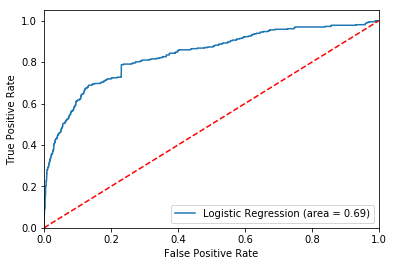

In [87]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [88]:
y_pred_df = pd.DataFrame({'y_pred': y_pred})

In [89]:
y_test = y_test.reset_index()

In [90]:
y_result = pd.concat([y_pred_df, y_test], axis=1)
y_result2 = y_result.set_index('index')

In [91]:
y_result2['error'] = np.where(y_result2['y_pred'] == y_result2['y'], 0, 1)

In [92]:
mean_sal = pd.DataFrame({'mean_sal': df['MN_EARN_WNE_P10']})

In [93]:
y_result3 = pd.merge(y_result2, mean_sal, left_index=True, right_index=True)

In [94]:
y_result3['mean_sal_err'] = y_result3['mean_sal']*y_result3['error']

In [95]:
y_result3['mean_sal_err'].replace(0, np.nan, inplace=True)

In [96]:
# Of the mistakes this model makes, find the average salary
error_mean_sal = y_result3['mean_sal_err'].mean()
print("The average salary of the misclassifications is ", error_mean_sal)

The average salary of the misclassifications is  57521.16788321168


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c17021b70>]],
      dtype=object)

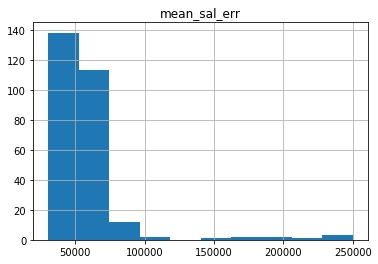

In [97]:
y_result3.hist(column='mean_sal_err')